In [ ]:
!pip install icrawler
%pip install icrawler
!pip install opencv-python
!pip install tensorflow

from google.colab import drive
import os
import cv2
import numpy as np
from icrawler.builtin import BingImageCrawler
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Define base directory
base_dir = '/content/drive/MyDrive/Cat_Subspecies_Dataset'
os.makedirs(base_dir, exist_ok=True)

Mounted at /content/drive


In [ ]:
classes = ['Siamese cat', 'Persian cat', 'Maine Coon cat']
images_per_class = 1000

for class_name in classes:
    output_dir = os.path.join(base_dir, 'raw', class_name.replace(' cat', ''))
    os.makedirs(output_dir, exist_ok=True)
    print(f"Downloading images for {class_name}...")
    try:
        crawler = BingImageCrawler(
            storage={'root_dir': output_dir},
            downloader_threads=2,  # Moderate threads to avoid rate limits
            parser_threads=2
        )
        crawler.crawl(
            keyword=class_name,
            max_num=images_per_class,
            min_size=(200, 200),  # Filter low-quality images
            file_idx_offset='auto',
            overwrite=False
        )
    except Exception as e:
        print(f"Error downloading {class_name}: {e}")

In [ ]:
# Step 1: Re-download Maine Coon images (if needed)
classes = ['Maine Coon cat']  # Only Maine Coon since others are fine
images_per_class = 1000

for class_name in classes:
    output_dir = os.path.join(base_dir, 'raw', class_name.replace(' cat', ''))
    os.makedirs(output_dir, exist_ok=True)
    print(f"Downloading images for {class_name}...")
    try:
        crawler = BingImageCrawler(
            storage={'root_dir': output_dir},
            downloader_threads=2,
            parser_threads=2
        )
        crawler.crawl(
            keyword=class_name,
            max_num=images_per_class,
            min_size=(200, 200),
            file_idx_offset='auto',
            overwrite=False
        )
    except Exception as e:
        print(f"Error downloading {class_name}: {e}")


In [ ]:
# Verify downloads
def count_images(directory):
    total = 0
    for root, _, files in os.walk(directory):
        total += len([f for f in files if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
    return total

raw_dir = os.path.join(base_dir, 'raw')
print(f"Total raw images: {count_images(raw_dir)}")
for class_name in ['Siamese', 'Persian', 'Maine_Coon']:
    print(f"{class_name}: {count_images(os.path.join(raw_dir, class_name))} images")

Total raw images: 4606
Siamese: 1804 images
Persian: 1581 images
Maine_Coon: 1221 images


In [ ]:
# Step 2: Standardize Data
def preprocess_image(image_path, target_size=(224, 224)):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None
        img = cv2.resize(img, target_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0
        return img
    except:
        return None

def save_image(img, path):
    img = (img * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, img)

In [ ]:
for split in ['train', 'validation', 'test']:
    for class_name in ['Siamese', 'Persian', 'Maine_Coon']:
        os.makedirs(os.path.join(base_dir, split, class_name), exist_ok=True)


In [ ]:
for class_name in ['Siamese', 'Persian', 'Maine_Coon']:
    raw_dir = os.path.join(base_dir, 'raw', class_name)
    image_paths = []

    for root, _, files in os.walk(raw_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))

    valid_images = []
    for path in image_paths:
        img = preprocess_image(path)
        if img is not None:
            valid_images.append(path)

    print(f"Valid images for {class_name}: {len(valid_images)}")

    if len(valid_images) == 0:
        print(f"Warning: No valid images for {class_name}. Skipping split and save.")
        continue

    train_paths, temp_paths = train_test_split(valid_images, train_size=0.7, random_state=42)
    val_paths, test_paths = train_test_split(temp_paths, train_size=0.5, random_state=42)

    for i, path in enumerate(train_paths):
        img = preprocess_image(path)
        if img is not None:
            save_image(img, os.path.join(base_dir, 'train', class_name, f'image_{i}.jpg'))

    for i, path in enumerate(val_paths):
        img = preprocess_image(path)
        if img is not None:
            save_image(img, os.path.join(base_dir, 'validation', class_name, f'image_{i}.jpg'))

    for i, path in enumerate(test_paths):
        img = preprocess_image(path)
        if img is not None:
            save_image(img, os.path.join(base_dir, 'test', class_name, f'image_{i}.jpg'))


Valid images for Siamese: 1804
Valid images for Persian: 1578
Valid images for Maine_Coon: 1221


In [ ]:
def count_images(directory):
    total = 0
    for root, _, files in os.walk(directory):
        total += len([f for f in files if f.endswith('.jpg')])
    return total

print(f"Training images: {count_images(os.path.join(base_dir, 'train'))}")
print(f"Validation images: {count_images(os.path.join(base_dir, 'validation'))}")
print(f"Test images: {count_images(os.path.join(base_dir, 'test'))}")
for split in ['train', 'validation', 'test']:
    for class_name in ['Siamese', 'Persian', 'Maine_Coon']:
        count = count_images(os.path.join(base_dir, split, class_name))
        print(f"{split}/{class_name}: {count} images")

Training images: 3220
Validation images: 691
Test images: 692
train/Siamese: 1262 images
train/Persian: 1104 images
train/Maine_Coon: 854 images
validation/Siamese: 271 images
validation/Persian: 237 images
validation/Maine_Coon: 183 images
test/Siamese: 271 images
test/Persian: 237 images
test/Maine_Coon: 184 images


In [ ]:
#Verify Dataset
print(f"Training images: {count_images(os.path.join(base_dir, 'train'))}")
print(f"Validation images: {count_images(os.path.join(base_dir, 'validation'))}")
print(f"Test images: {count_images(os.path.join(base_dir, 'test'))}")
for split in ['train', 'validation', 'test']:
    for class_name in ['Siamese', 'Persian', 'Maine_Coon']:
        count = count_images(os.path.join(base_dir, split, class_name))
        print(f"{split}/{class_name}: {count} images")

Training images: 3220
Validation images: 691
Test images: 692
train/Siamese: 1262 images
train/Persian: 1104 images
train/Maine_Coon: 854 images
validation/Siamese: 271 images
validation/Persian: 237 images
validation/Maine_Coon: 183 images
test/Siamese: 271 images
test/Persian: 237 images
test/Maine_Coon: 184 images


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
base_dir = '/content/drive/MyDrive/Cat_Subspecies_Dataset'
img_size = (224, 224)
batch_size = 32
num_classes = 3
class_names = ['Siamese', 'Persian', 'Maine_Coon']

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(base_dir, 'validation'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

print("Datasets loaded successfully!")

Found 3220 files belonging to 3 classes.
Found 691 files belonging to 3 classes.
Found 692 files belonging to 3 classes.
Datasets loaded successfully!


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

# Apply augmentation to training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
# Load pre-trained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base layers

# Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.3949 - loss: 61.2104

101/101 ━━━━━━━━━━━━━━━━━━━━ 63s 526ms/step - accuracy: 0.3956 - loss: 60.7691 - val_accuracy: 0.5658 - val_loss: 0.9760
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 67s 456ms/step - accuracy: 0.5582 - loss: 0.9939 - val_accuracy: 0.4399 - val_loss: 1.0555
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.5455 - loss: 1.0004

101/101 ━━━━━━━━━━━━━━━━━━━━ 47s 460ms/step - accuracy: 0.5457 - loss: 1.0001 - val_accuracy: 0.5673 - val_loss: 0.8793
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.5652 - loss: 0.9523

101/101 ━━━━━━━━━━━━━━━━━━━━ 46s 451ms/step - accuracy: 0.5653 - loss: 0.9521 - val_accuracy: 0.5760 - val_loss: 0.9171
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 47s 460ms/step - accuracy: 0.5747 - loss: 0.9318 - val_accuracy: 0.5687 - val_loss: 0.9490
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.5874 - loss: 0.9106

101/101 ━━━━━━━━━━━━━━━━━━━━ 82s 461ms/step - accuracy: 0.5876 - loss: 0.9103 - val_accuracy: 0.6483 - val_loss: 0.8094
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 47s 451ms/step - accuracy: 0.6183 - loss: 0.8615 - val_accuracy: 0.6151 - val_loss: 0.9389
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 81s 454ms/step - accuracy: 0.6149 - loss: 0.8673 - val_accuracy: 0.6425 - val_loss: 0.8101
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.6597 - loss: 0.8399

101/101 ━━━━━━━━━━━━━━━━━━━━ 82s 458ms/step - accuracy: 0.6597 - loss: 0.8396 - val_accuracy: 0.6831 - val_loss: 0.7413
Epoch 10/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 83s 462ms/step - accuracy: 0.6378 - loss: 0.8234 - val_accuracy: 0.6700 - val_loss: 0.7840
Epoch 11/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.6443 - loss: 0.8214

101/101 ━━━━━━━━━━━━━━━━━━━━ 81s 460ms/step - accuracy: 0.6446 - loss: 0.8210 - val_accuracy: 0.6889 - val_loss: 0.7178
Epoch 12/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.6677 - loss: 0.7502

101/101 ━━━━━━━━━━━━━━━━━━━━ 83s 469ms/step - accuracy: 0.6678 - loss: 0.7501 - val_accuracy: 0.7091 - val_loss: 0.7023
Epoch 13/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 45s 443ms/step - accuracy: 0.6976 - loss: 0.7378 - val_accuracy: 0.7077 - val_loss: 0.7600
Epoch 14/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.7021 - loss: 0.7167

101/101 ━━━━━━━━━━━━━━━━━━━━ 84s 461ms/step - accuracy: 0.7022 - loss: 0.7165 - val_accuracy: 0.7294 - val_loss: 0.6386
Epoch 15/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.6969 - loss: 0.7154

101/101 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.6971 - loss: 0.7152 - val_accuracy: 0.7424 - val_loss: 0.6954
Epoch 16/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 81s 451ms/step - accuracy: 0.7265 - loss: 0.6644 - val_accuracy: 0.7337 - val_loss: 0.6613
Epoch 17/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.7227 - loss: 0.6740

101/101 ━━━━━━━━━━━━━━━━━━━━ 82s 450ms/step - accuracy: 0.7230 - loss: 0.6736 - val_accuracy: 0.7612 - val_loss: 0.6261
Epoch 18/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.7483 - loss: 0.6274

101/101 ━━━━━━━━━━━━━━━━━━━━ 47s 461ms/step - accuracy: 0.7483 - loss: 0.6276 - val_accuracy: 0.7670 - val_loss: 0.5911
Epoch 19/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.7265 - loss: 0.6690

101/101 ━━━━━━━━━━━━━━━━━━━━ 81s 449ms/step - accuracy: 0.7266 - loss: 0.6686 - val_accuracy: 0.7742 - val_loss: 0.6053
Epoch 20/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.7305 - loss: 0.6570

101/101 ━━━━━━━━━━━━━━━━━━━━ 83s 458ms/step - accuracy: 0.7307 - loss: 0.6565 - val_accuracy: 0.7844 - val_loss: 0.5601
Epoch 21/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.7666 - loss: 0.5786 - val_accuracy: 0.7583 - val_loss: 0.5881
Epoch 22/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.7689 - loss: 0.5830

101/101 ━━━━━━━━━━━━━━━━━━━━ 46s 451ms/step - accuracy: 0.7689 - loss: 0.5829 - val_accuracy: 0.8162 - val_loss: 0.5094
Epoch 23/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.7970 - loss: 0.5407

101/101 ━━━━━━━━━━━━━━━━━━━━ 84s 468ms/step - accuracy: 0.7968 - loss: 0.5408 - val_accuracy: 0.8234 - val_loss: 0.4894
Epoch 24/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 46s 455ms/step - accuracy: 0.7618 - loss: 0.5784 - val_accuracy: 0.7800 - val_loss: 0.5826
Epoch 25/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 82s 451ms/step - accuracy: 0.7732 - loss: 0.5749 - val_accuracy: 0.7482 - val_loss: 0.6017
Epoch 26/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.8088 - loss: 0.5087

101/101 ━━━━━━━━━━━━━━━━━━━━ 82s 458ms/step - accuracy: 0.8088 - loss: 0.5086 - val_accuracy: 0.8307 - val_loss: 0.4806
Epoch 27/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.7770 - loss: 0.5444

101/101 ━━━━━━━━━━━━━━━━━━━━ 48s 470ms/step - accuracy: 0.7770 - loss: 0.5443 - val_accuracy: 0.8321 - val_loss: 0.4279
Epoch 28/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 46s 452ms/step - accuracy: 0.8157 - loss: 0.4954 - val_accuracy: 0.8162 - val_loss: 0.4441
Epoch 29/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 83s 461ms/step - accuracy: 0.8113 - loss: 0.4908 - val_accuracy: 0.8177 - val_loss: 0.4457
Epoch 30/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 80s 443ms/step - accuracy: 0.8110 - loss: 0.4766 - val_accuracy: 0.7742 - val_loss: 0.5549


In [ ]:
#Create TensorFlow Datasets
try:
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(base_dir, 'train'),
        image_size=(224, 224),
        batch_size=32,
        label_mode='categorical'
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(base_dir, 'validation'),
        image_size=(224, 224),
        batch_size=32,
        label_mode='categorical'
    )

    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(base_dir, 'test'),
        image_size=(224, 224),
        batch_size=32,
        label_mode='categorical'
    )

    print("Dataset created successfully!")
except Exception as e:
    print(f"Error creating TensorFlow datasets: {e}")

Found 3220 files belonging to 3 classes.
Found 691 files belonging to 3 classes.
Found 692 files belonging to 3 classes.
Dataset created successfully!


In [ ]:
!pip install tensorflow scikit-learn

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score
import time
import os
from functools import partial

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load and Preprocess Dataset
#Goal: Load the dataset and apply data augmentation
#1. Define Parameters:
base_dir = '/content/drive/MyDrive/Cat_Subspecies_Dataset'
img_size = (224, 224)
batch_size = 32
num_classes = 3
class_names = ['Siamese', 'Persian', 'Maine_Coon']

In [ ]:
#Load Datasets:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(base_dir, 'validation'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

print("Datasets loaded successfully!")

Found 3220 files belonging to 3 classes.
Found 691 files belonging to 3 classes.
Found 692 files belonging to 3 classes.
Datasets loaded successfully!


In [ ]:
#Optimize Data Loading:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#Define mAP Metric
def compute_mAP(model, dataset, class_names):
    y_true = []
    y_score = []
    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_score.extend(preds)

    y_true = np.array(y_true)
    y_score = np.array(y_score)

    ap_scores = []
    for i in range(len(class_names)):
        ap = average_precision_score(y_true[:, i], y_score[:, i])
        ap_scores.append(ap)

    return np.mean(ap_scores)

In [ ]:
#Build and Train Models

#Goal: Train ResNet50, DenseNet121, and MobileNetV3 for 50 epochs each, recording accuracy, mAP, and training time.

#1. Define Model Builder Function

def build_model(base_model, num_classes):
    base_model.trainable = False  # Freeze base layers
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
#2 Train Each Model:
import tensorflow as tf
from tensorflow.keras import applications
from functools import partial
import time
import os

models_dict = {
    'ResNet50': applications.ResNet50,
    'DenseNet121': applications.DenseNet121,
    'MobileNetV3': partial(applications.MobileNetV3Large, alpha=1.0)
}

results = {}
for model_name, model_fn in models_dict.items():
    print(f"\nTraining {model_name}...")

    # Initialize base model
    base_model = model_fn(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )

    # Build and compile model
    model = build_model(base_model, num_classes)

    # Define callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            f'{model_name}_best.keras',
            monitor='val_accuracy',
            save_best_only=True
        )
    ]




Training ResNet50...

Training DenseNet121...

Training MobileNetV3...


In [ ]:
# Train models

models_dict = {
    'ResNet50': applications.ResNet50,
    'DenseNet121': applications.DenseNet121,
    'MobileNetV3': partial(applications.MobileNetV3Large, alpha=1.0)
}

results = {}
for model_name, model_fn in models_dict.items():
    result = train_and_time_model(
        model_fn=model_fn,
        model_name=model_name,
        train_ds=train_ds,
        val_ds=val_ds,
        test_ds=test_ds,
        class_names=class_names,
        num_classes=num_classes,
        base_dir=base_dir
    )
    results[model_name] = result


Training ResNet50...
Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 56s 259ms/step - accuracy: 0.8000 - loss: 0.5433 - val_accuracy: 0.9638 - val_loss: 0.1144
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.9563 - loss: 0.1336 - val_accuracy: 0.9696 - val_loss: 0.0788
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.9755 - loss: 0.0788 - val_accuracy: 0.9841 - val_loss: 0.0398
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.9820 - loss: 0.0524 - val_accuracy: 0.9913 - val_loss: 0.0264
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.9899 - loss: 0.0354 - val_accuracy: 0.9942 - val_loss: 0.0268
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.9860 - loss: 0.0370 - val_accuracy: 0.9942 - val_loss: 0.0278
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9971 - loss: 0.0193 - val_accuracy: 0.9942 - val_loss: 0.0183
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 

In [ ]:
#Define the Training and Timing Function

def train_and_time_model(model_fn, model_name, train_ds, val_ds, test_ds, class_names, num_classes, base_dir):
    print(f"\nTraining {model_name}...")

    # Initialize base model
    base_model = model_fn(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )

    # Build and compile model
    model = build_model(base_model, num_classes)

    # Define callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            f'{model_name}_best.keras',
            monitor='val_accuracy',
            save_best_only=True
        )
    ]

    # Record training time
    start_time = time.time()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks,
        verbose=1
    )
    training_time = time.time() - start_time

    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
    test_mAP = compute_mAP(model, test_ds, class_names)

    # Save model
    model.save(os.path.join(base_dir, f'{model_name}_model.keras'))

    # Print results
    print(f"{model_name} - Training time: {training_time:.2f} seconds")
    print(f"{model_name} - Test accuracy: {test_accuracy:.4f}")
    print(f"{model_name} - Test mAP: {test_mAP:.4f}")

    return {
        'history': history.history,
        'training_time': training_time,
        'test_accuracy': test_accuracy,
        'test_mAP': test_mAP
    }

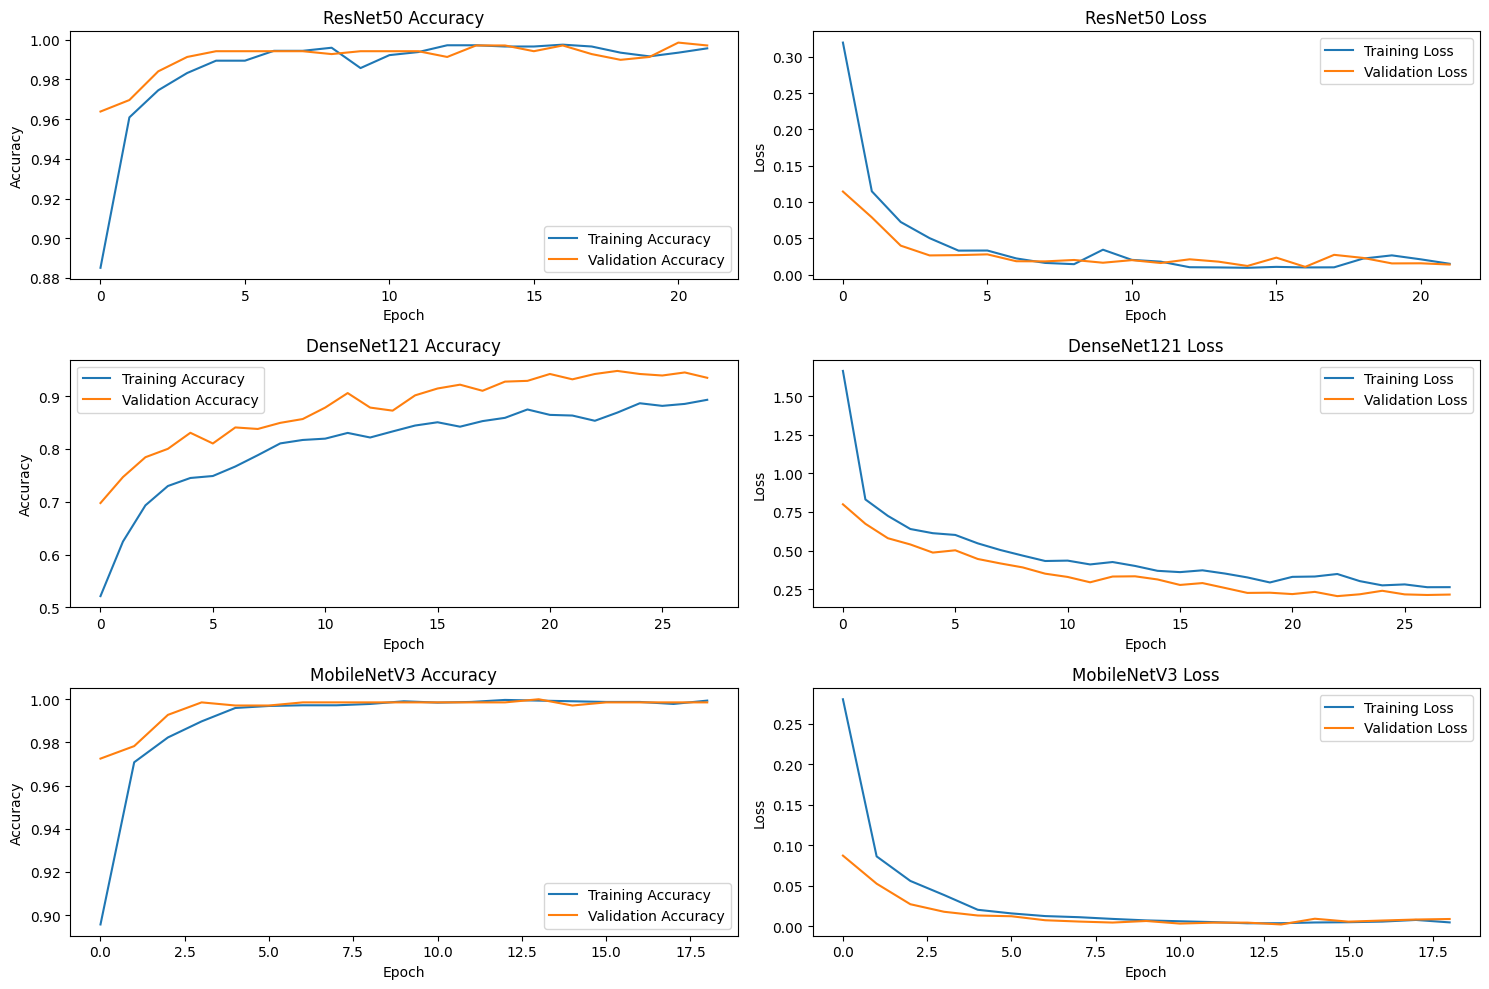

In [ ]:
#Visualize and Compare Results

#1. Plot Accuracy and Loss Curves:

plt.figure(figsize=(15, 10))
for i, (model_name, result) in enumerate(results.items(), 1):
    history = result['history']
    epochs_range = range(len(history['accuracy']))

    plt.subplot(3, 2, i*2-1)
    plt.plot(epochs_range, history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(3, 2, i*2)
    plt.plot(epochs_range, history['loss'], label='Training Loss')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()

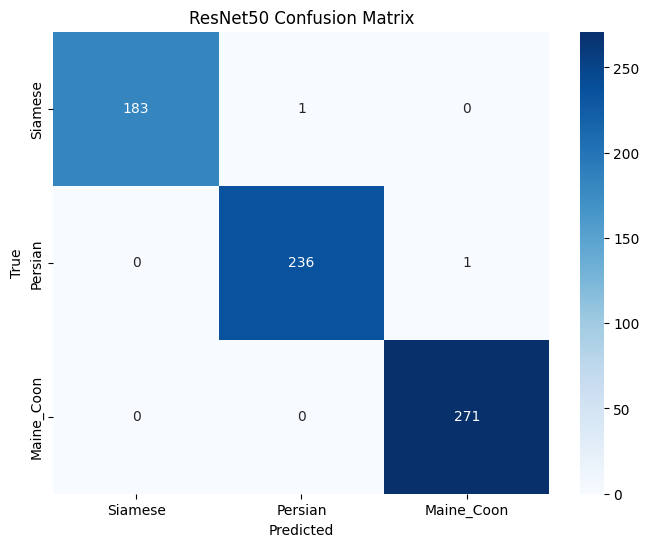


ResNet50 Classification Report:
              precision    recall  f1-score   support

     Siamese       1.00      0.99      1.00       184
     Persian       1.00      1.00      1.00       237
  Maine_Coon       1.00      1.00      1.00       271

    accuracy                           1.00       692
   macro avg       1.00      1.00      1.00       692
weighted avg       1.00      1.00      1.00       692



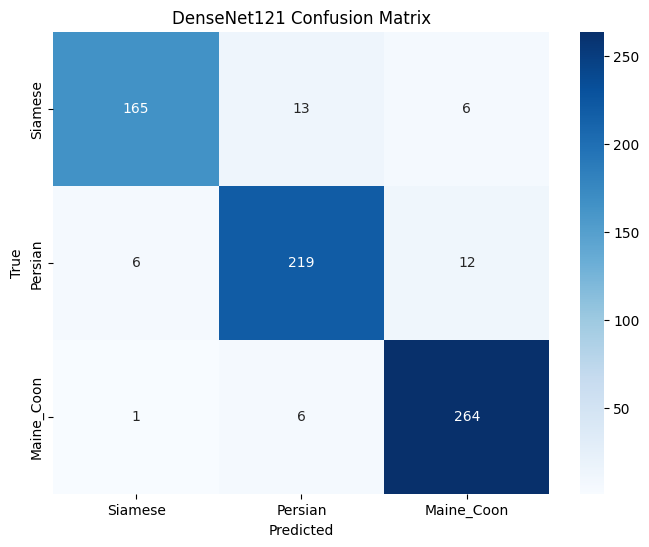


DenseNet121 Classification Report:
              precision    recall  f1-score   support

     Siamese       0.96      0.90      0.93       184
     Persian       0.92      0.92      0.92       237
  Maine_Coon       0.94      0.97      0.95       271

    accuracy                           0.94       692
   macro avg       0.94      0.93      0.93       692
weighted avg       0.94      0.94      0.94       692



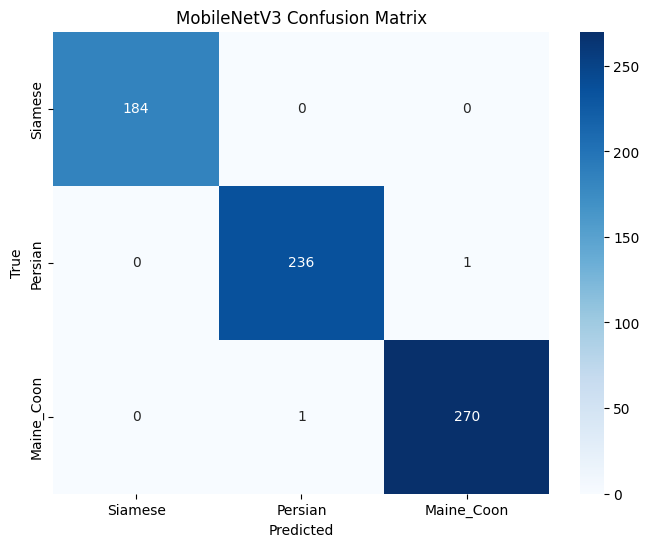


MobileNetV3 Classification Report:
              precision    recall  f1-score   support

     Siamese       1.00      1.00      1.00       184
     Persian       1.00      1.00      1.00       237
  Maine_Coon       1.00      1.00      1.00       271

    accuracy                           1.00       692
   macro avg       1.00      1.00      1.00       692
weighted avg       1.00      1.00      1.00       692



In [ ]:
#Confusion Matrices

for model_name in models_dict.keys():
    model = tf.keras.models.load_model(os.path.join(base_dir, f'{model_name}_model.keras'))
    y_true = []
    y_pred = []
    for images, labels in test_ds:
        preds = model.predict(images, verbose=0)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
#Summarize Results:

print("\nModel Comparison:")
print(f"{'Model':<15} {'Test Accuracy':<15} {'Test mAP':<15} {'Training Time (s)':<20}")
print("-" * 65)
for model_name, result in results.items():
    print(f"{model_name:<15} {result['test_accuracy']:<15.4f} {result['test_mAP']:<15.4f} {result['training_time']:<20.2f}")


Model Comparison:
Model           Test Accuracy   Test mAP        Training Time (s)   
-----------------------------------------------------------------
ResNet50        0.9971          0.9994          281.23              
DenseNet121     0.9364          0.9755          335.49              
MobileNetV3     0.9971          0.9996          113.05              


In [ ]:
# Add parameter counts
param_counts = {}
for model_name, model_fn in models_dict.items():
    base_model = model_fn(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    model = build_model(base_model, num_classes)
    param_counts[model_name] = model.count_params()

In [ ]:
# Update results with parameter counts
for model_name in results:
    results[model_name]['param_count'] = param_counts[model_name]

In [ ]:
# Load or recompute history for plots (if available)
history_files = {model_name: os.path.join(base_dir, f'{model_name}_history.npy') for model_name in models_dict}
for model_name in models_dict:
    if os.path.exists(history_files[model_name]):
        results[model_name]['history'] = np.load(history_files[model_name], allow_pickle=True).item()
    elif 'history' not in results[model_name]:
        results[model_name]['history'] = None
        print(f"History for {model_name} not found. Skipping loss/accuracy plots.")

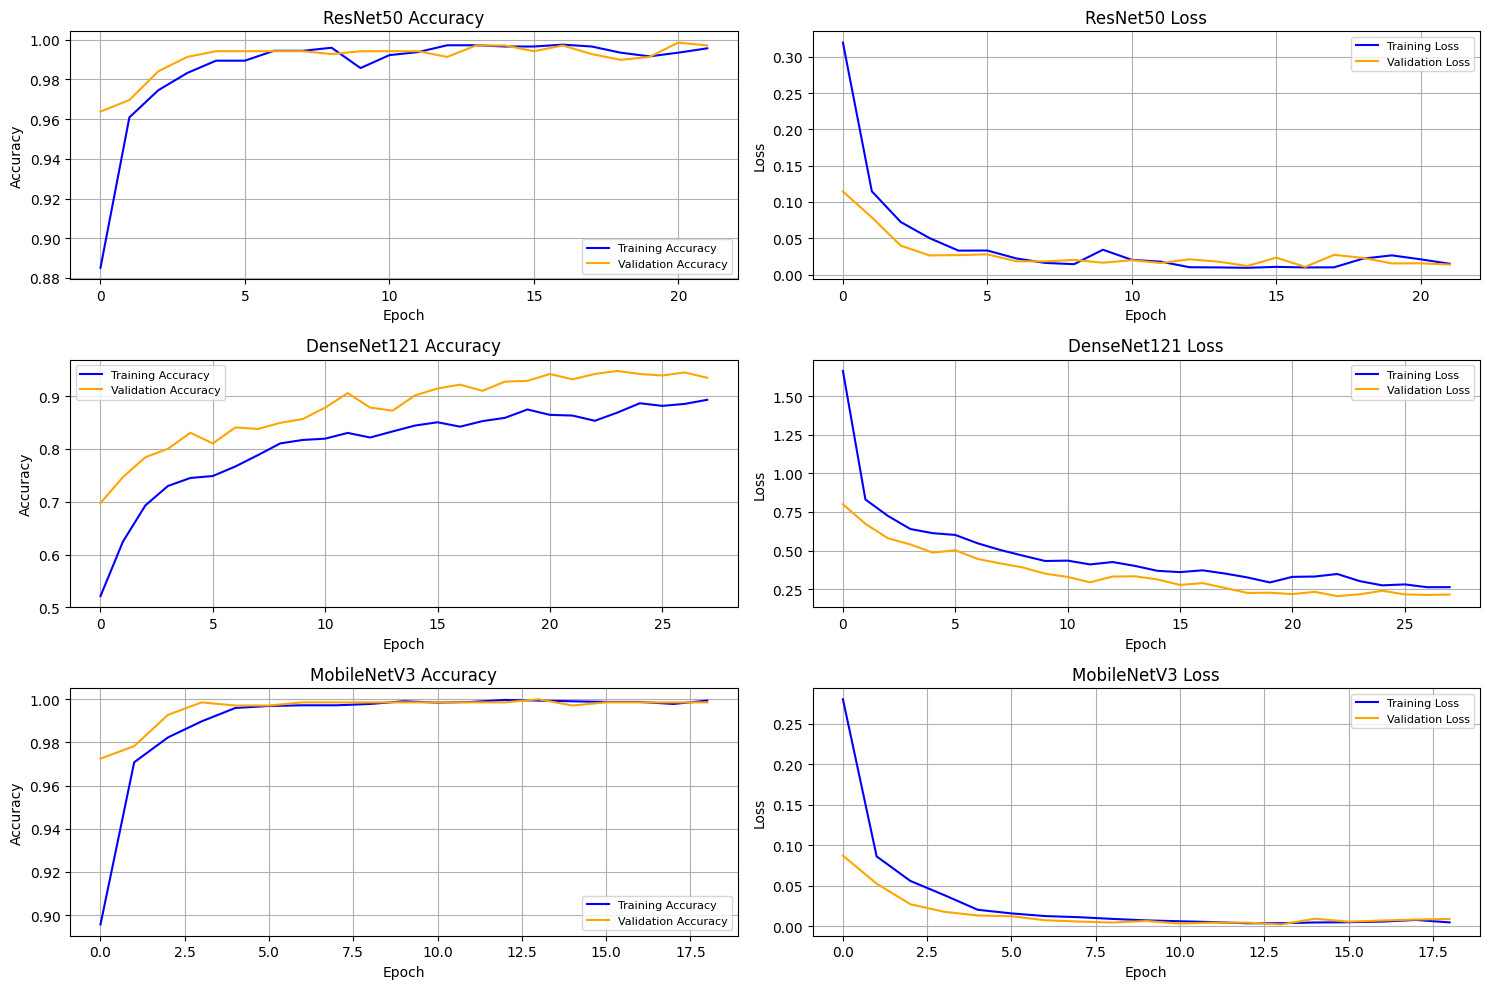

In [ ]:
# Visualize loss and accuracy
plt.figure(figsize=(15, 10))
for i, model_name in enumerate(models_dict.keys(), 1):
    if results[model_name].get('history'):
        history = results[model_name]['history']
        epochs_range = range(len(history['accuracy']))

        plt.subplot(3, 2, i*2-1)
        plt.plot(epochs_range, history['accuracy'], label='Training Accuracy', color='blue')
        plt.plot(epochs_range, history['val_accuracy'], label='Validation Accuracy', color='orange')
        plt.title(f'{model_name} Accuracy', fontsize=12)
        plt.xlabel('Epoch', fontsize=10)
        plt.ylabel('Accuracy', fontsize=10)
        plt.legend(fontsize=8)
        plt.grid(True)

        plt.subplot(3, 2, i*2)
        plt.plot(epochs_range, history['loss'], label='Training Loss', color='blue')
        plt.plot(epochs_range, history['val_loss'], label='Validation Loss', color='orange')
        plt.title(f'{model_name} Loss', fontsize=12)
        plt.xlabel('Epoch', fontsize=10)
        plt.ylabel('Loss', fontsize=10)
        plt.legend(fontsize=8)
        plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(base_dir, 'model_loss_accuracy_plots.png'), dpi=300)
plt.show()

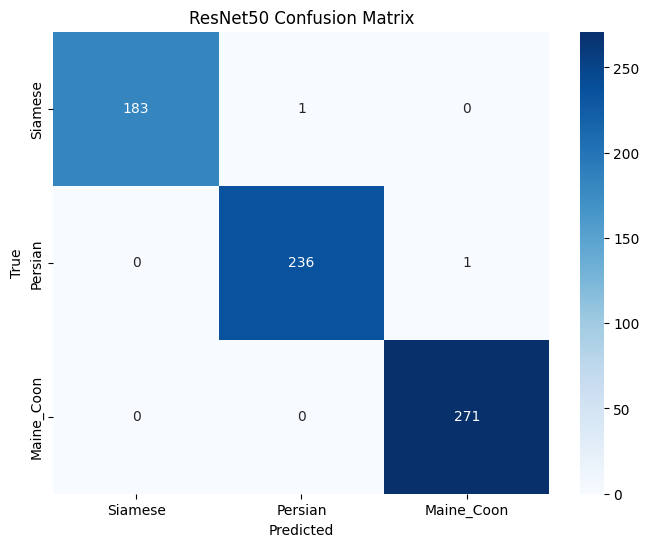


ResNet50 Classification Report:
              precision    recall  f1-score   support

     Siamese       1.00      0.99      1.00       184
     Persian       1.00      1.00      1.00       237
  Maine_Coon       1.00      1.00      1.00       271

    accuracy                           1.00       692
   macro avg       1.00      1.00      1.00       692
weighted avg       1.00      1.00      1.00       692



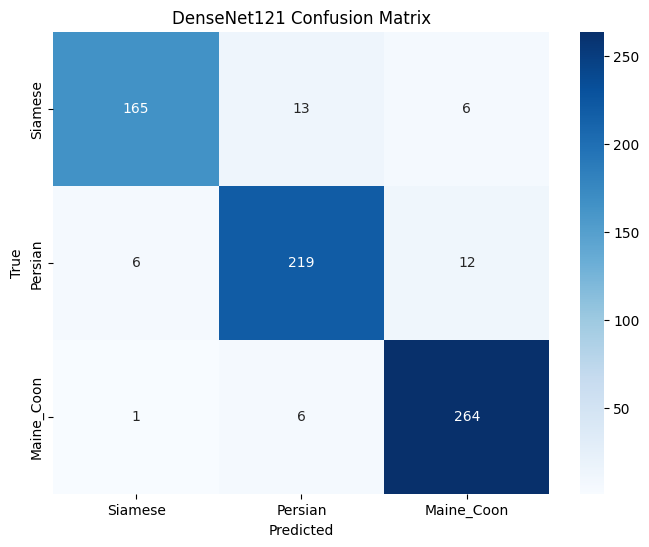


DenseNet121 Classification Report:
              precision    recall  f1-score   support

     Siamese       0.96      0.90      0.93       184
     Persian       0.92      0.92      0.92       237
  Maine_Coon       0.94      0.97      0.95       271

    accuracy                           0.94       692
   macro avg       0.94      0.93      0.93       692
weighted avg       0.94      0.94      0.94       692



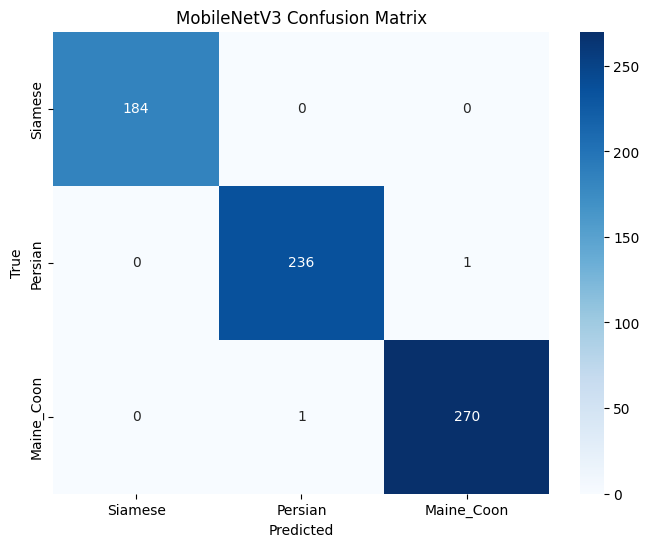


MobileNetV3 Classification Report:
              precision    recall  f1-score   support

     Siamese       1.00      1.00      1.00       184
     Persian       1.00      1.00      1.00       237
  Maine_Coon       1.00      1.00      1.00       271

    accuracy                           1.00       692
   macro avg       1.00      1.00      1.00       692
weighted avg       1.00      1.00      1.00       692



In [ ]:
# Confusion matrices
for model_name in models_dict.keys():
    model_path = os.path.join(base_dir, f'{model_name}_model.keras')
    if os.path.exists(model_path):
        model = tf.keras.models.load_model(model_path)
        y_true = []
        y_pred = []
        for images, labels in test_ds:
            preds = model.predict(images, verbose=0)
            y_true.extend(np.argmax(labels.numpy(), axis=1))
            y_pred.extend(np.argmax(preds, axis=1))

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'{model_name} Confusion Matrix', fontsize=12)
        plt.xlabel('Predicted', fontsize=10)
        plt.ylabel('True', fontsize=10)
        plt.savefig(os.path.join(base_dir, f'{model_name}_confusion_matrix.png'), dpi=300)
        plt.show()

        print(f"\n{model_name} Classification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
!pip install pandas

In [ ]:
# Summarize results
import pandas as pd
metrics_df = pd.DataFrame({
    'Model': [name for name in results],
    'Test Accuracy': [results[name]['test_accuracy'] for name in results],
    'Test mAP': [results[name]['test_mAP'] for name in results],
    'Training Time (s)': [results[name]['training_time'] for name in results],
    'Parameters (M)': [results[name]['param_count'] / 1e6 for name in results]
})
metrics_df.to_csv(os.path.join(base_dir, 'model_metrics_updated.csv'), index=False)

print("\nModel Performance Summary:")
print(metrics_df.round(4))


Model Performance Summary:
         Model  Test Accuracy  Test mAP  Training Time (s)  Parameters (M)
0     ResNet50         0.9971    0.9994           281.2346         23.8504
1  DenseNet121         0.9364    0.9755           335.4936          7.1691
2  MobileNetV3         0.9971    0.9996           113.0542          3.1197
